# Test the 2020 AERR emission quantity sensitivity b/w old and new VMT Mix
Created by: Apoorb
--
Questions:
1. What is the statewide impact of change in VMT-Mix?
2. What is the impact on non-attainment areas w.r.t pollutant of interest?
3. What are the patterns in VMT-Mix difference? What is the likely cause?
4. What is the story??????

## Housekeeping

In [1]:
import sys

sys.path.append(r"C:\Users\a-bibeka\PycharmProjects\FY23_VMT_Mix")

In [2]:
import pathlib
from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from vmtmix_fy23.utils import path_county_shp

Set Paths

In [3]:
path_aerr20_csvs = Path(
    r"E:\Texas A&M Transportation Institute\TxDOT_TPP_Projects - Task 5.3 Activity Forecasting Factors\Data\fy23_vmt_mix\Input\aerr20_output"
)
path_sutft_act = Path.joinpath(path_aerr20_csvs, "mvs303_act_sutft.csv")
path_sutft_emis = Path.joinpath(path_aerr20_csvs, "mvs303_emis_sutft.csv")
path_vmtmix_fy22_13_19 = Path(
    r"E:\Texas A&M Transportation Institute\TxDOT_TPP_Projects - Task 5.3 Activity Forecasting Factors\Data\fy23_vmt_mix\output\fy22_fin_vmtmix_13_19_042022.csv"
)

path_vmtmix_fy23_13_21 = Path(
    r"E:\Texas A&M Transportation Institute\TxDOT_TPP_Projects - Task 5.3 Activity Forecasting Factors\Data\fy23_vmt_mix\output\fy23_fin_vmtmix_13_21_032023.csv"
)

Analysis FIPS

In [4]:
gdf_county = gpd.read_file(path_county_shp)
district_map = gdf_county[["TXDOT_DIST", "FIPS_ST_CN"]].astype(int)

hgb_fips = [48201, 48039, 48157, 48473, 48339, 48291, 48071, 48167]
san_fips = [48029, 48091, 48187, 48259, 48493]
hgb_san_fips = list(hgb_fips) + list(san_fips)
fips_254 = list(district_map.FIPS_ST_CN.unique())
analysis_fips = fips_254


district_map_anly = district_map.loc[
    district_map.FIPS_ST_CN.isin(analysis_fips)
].rename(columns={"FIPS_ST_CN": "fips", "TXDOT_DIST": "txdot_dist"})

## Process AERR20 SUT-FT Emission and Activity to get County-level VMT and Emission Rates

In [5]:
sutft_act = pd.read_csv(path_sutft_act)
suft_emis = pd.read_csv(path_sutft_emis)

### Get county-level VMT and filter to VMT activity.

In [6]:
sutft_vmt = sutft_act.loc[sutft_act.mvs_act_type == "vmt"]
sutft_vmt = sutft_vmt.rename(columns={"activity": "vmt"})
sutft_vmt["vmt_agg"] = sutft_vmt.groupby(
    [
        "county",
        "fips",
        "year_id",
        "road_type_id",
        "roadtype_lab",
        "activity_type_id",
        "mvs_act_type",
        "act_em_lab",
    ]
).vmt.transform(sum)
sutft_vmt = sutft_vmt.filter(
    items=[
        "county",
        "fips",
        "year_id",
        "road_type_id",
        "roadtype_lab",
        "activity_type_id",
        "mvs_act_type",
        "source_type_id",
        "fuel_type_id",
        "sut_fueltype_lab",
        "act_em_lab",
        "vmt",
        "vmt_agg",
    ]
)

### Back-calculate Emission On-raod Emission Rate.

In [7]:
suft_emis.process_lab.unique()

array(['Running_Exh', 'Start_Exh', 'Crank_Run_Exh', 'Crank_Start_Exh',
       'Crank_Ext_Idle', 'Ext_Idle_Exh', 'Aux_Power_Exh',
       'Evap_Permeation', 'Evap_Fuel_Vent', 'Evap_Fuel_Leak', 'Brakewear',
       'Tirewear'], dtype=object)

In [8]:
# Note that 'pollutant_id' and 'short_name_mvs3' are different from 'eis_poll_nei17' and 'short_name_nei17'. 'short_name_mvs3' for instance has PM10 exhaust, brakewear, and tirewear. While NEI combines the three. I am removing MOVES pollutant for this analysis.
suft_emis_1 = (
    suft_emis.loc[
        (
            suft_emis.process_lab.isin(
                [
                    "Running_Exh",
                    "Crank_Run_Exh",
                    "Brakewear",
                    "Tirewear",
                    "Evap_Permeation",
                    "Evap_Fuel_Vent",
                    "Evap_Fuel_Leak",
                ]
            )
        )
        & (suft_emis.road_type_id != 1)
    ]
    .groupby(
        [
            "county",
            "fips",
            "year_id",
            "road_type_id",
            "roadtype_lab",
            "eis_poll_nei17",
            "short_name_nei17",
            "source_type_id",
            "fuel_type_id",
        ],
        as_index=False,
    )
    .emission_quant.sum()
)

In [9]:
suft_emis.loc[
    lambda df: df.eis_poll_nei17 == "PM10-PRI", ["eis_poll_nei17", "short_name_mvs3"]
].drop_duplicates()

,eis_poll_nei17,short_name_mvs3
3168,PM10-PRI,PM10 Total Exh
6434,PM10-PRI,PM10 Brakewear
6456,PM10-PRI,PM10 Tirewear


In [10]:
suft_emis.loc[
    lambda df: (
        df.eis_poll_nei17.isin(
            ["CO", "SO2", "NOX", "VOC", "CO2", "PM10-PRI", "PM25-PRI", 71432]
        )
    )
    & (df.road_type_id == 1),
    ["eis_poll_nei17", "process_lab"],
].drop_duplicates().sort_values(["eis_poll_nei17", "process_lab"])

,eis_poll_nei17,process_lab
90,CO,Aux_Power_Exh
88,CO,Crank_Ext_Idle
44,CO,Crank_Run_Exh
66,CO,Crank_Start_Exh
89,CO,Ext_Idle_Exh
0,CO,Running_Exh
22,CO,Start_Exh
3167,CO2,Aux_Power_Exh
3166,CO2,Ext_Idle_Exh
3122,CO2,Running_Exh


In [11]:
suft_emis.loc[
    lambda df: (
        df.eis_poll_nei17.isin(
            ["CO", "SO2", "NOX", "VOC", "CO2", "PM10-PRI", "PM25-PRI", 71432]
        )
    )
    & (df.road_type_id != 1),
    ["eis_poll_nei17", "process_lab"],
].drop_duplicates().sort_values(["eis_poll_nei17", "process_lab"])

,eis_poll_nei17,process_lab
4828,CO,Crank_Run_Exh
4806,CO,Running_Exh
6368,CO2,Running_Exh
4872,NOX,Crank_Run_Exh
4850,NOX,Running_Exh
6434,PM10-PRI,Brakewear
6412,PM10-PRI,Crank_Run_Exh
6390,PM10-PRI,Running_Exh
6456,PM10-PRI,Tirewear
6522,PM25-PRI,Brakewear


In [12]:
suft_emis.loc[
    lambda df: (df.eis_poll_nei17 == "VOC") & (df.road_type_id != 1),
    ["eis_poll_nei17", "process_lab"],
].drop_duplicates()

,eis_poll_nei17,process_lab
6324,VOC,Running_Exh
6346,VOC,Crank_Run_Exh
9364,VOC,Evap_Permeation
9374,VOC,Evap_Fuel_Vent
9384,VOC,Evap_Fuel_Leak


In [13]:
suft_emis_vmt = suft_emis_1.merge(
    sutft_vmt,
    on=[
        "county",
        "fips",
        "year_id",
        "road_type_id",
        "roadtype_lab",
        "source_type_id",
        "fuel_type_id",
    ],
    how="left",
)

In [14]:
suft_emis_vmt_onroad = suft_emis_vmt.loc[
    lambda df: (df.road_type_id != 1) & (df.vmt != 0)
]
suft_emis_vmt_onroad["emission_rate_calc"] = (
    suft_emis_vmt_onroad.emission_quant / suft_emis_vmt_onroad.vmt
)

C:\Users\a-bibeka\AppData\Local\Temp\ipykernel_22872\1773013509.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suft_emis_vmt_onroad["emission_rate_calc"] = (


Filter to Analysis FIPS and get Dennis's VMT-Mix from the Data

In [15]:
suft_emis_vmt_onroad_anly = suft_emis_vmt_onroad.loc[
    lambda df: df.fips.isin(analysis_fips)
]
suft_emis_vmt_onroad_anly["vmt_mix_dp"] = (
    suft_emis_vmt_onroad_anly.vmt / suft_emis_vmt_onroad_anly.vmt_agg
)

## Load FY22 and F23 VMT-Mix Created by AxB

In [16]:
vmtmix_fy22_13_19 = pd.read_csv(path_vmtmix_fy22_13_19)
vmtmix_fy23_13_21 = pd.read_csv(path_vmtmix_fy23_13_21)

Process FY22 2013 -- 2019 VMT-Mix and add suffix.

In [17]:
vmtmix_fy22_13_19 = vmtmix_fy22_13_19.merge(district_map_anly, on="txdot_dist")
assert (
    set(vmtmix_fy22_13_19.fips.unique()).symmetric_difference(set(analysis_fips))
    == set()
)
vmtmix_fy22_13_19_filt = vmtmix_fy22_13_19.loc[
    lambda df: (df.dowagg == "Wkd")
    & (df.tod == "day")
    & (df.mvs_rdtype_nm != "ALL")
    & (df.yearID == 2020)
]
assert len(analysis_fips) * 24 * 4 == len(vmtmix_fy22_13_19_filt)
vmtmix_fy22_13_19_filt["road_type_id"] = vmtmix_fy22_13_19_filt.mvs_rdtype.astype(int)
vmtmix_fy22_13_19_filt = vmtmix_fy22_13_19_filt.filter(
    items=["fips", "district", "road_type_id", "sourceTypeID", "fuelTypeID", "vmt_mix"]
).rename(
    columns={
        "sourceTypeID": "source_type_id",
        "fuelTypeID": "fuel_type_id",
        "vmt_mix": "vmt_mix_fy22_13_19",
    }
)

C:\Users\a-bibeka\AppData\Local\Temp\ipykernel_22872\4134271923.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vmtmix_fy22_13_19_filt["road_type_id"] = vmtmix_fy22_13_19_filt.mvs_rdtype.astype(int)


Process FY23 2013 -- 2021 VMT-Mix and add suffix.

In [18]:
vmtmix_fy23_13_21 = vmtmix_fy23_13_21.merge(district_map_anly, on="txdot_dist")
assert (
    set(vmtmix_fy23_13_21.fips.unique()).symmetric_difference(set(analysis_fips))
    == set()
)
vmtmix_fy23_13_21_filt = vmtmix_fy23_13_21.loc[
    lambda df: (df.dowagg == "Wkd")
    & (df.tod == "day")
    & (df.mvs_rdtype_nm != "ALL")
    & (df.yearID == 2020)
]
assert len(analysis_fips) * 24 * 4 == len(vmtmix_fy23_13_21_filt)
vmtmix_fy23_13_21_filt["road_type_id"] = vmtmix_fy23_13_21_filt.mvs_rdtype.astype(int)
vmtmix_fy23_13_21_filt = vmtmix_fy23_13_21_filt.filter(
    items=["fips", "district", "road_type_id", "sourceTypeID", "fuelTypeID", "vmt_mix"]
).rename(
    columns={
        "sourceTypeID": "source_type_id",
        "fuelTypeID": "fuel_type_id",
        "vmt_mix": "vmt_mix_fy23_13_21",
    }
)

C:\Users\a-bibeka\AppData\Local\Temp\ipykernel_22872\3699093946.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vmtmix_fy23_13_21_filt["road_type_id"] = vmtmix_fy23_13_21_filt.mvs_rdtype.astype(int)


## Merge AERR 2020 Processed Data with New VMT-Mixes

In [19]:
suft_emis_vmt_onroad_anly.columns

Index(['county', 'fips', 'year_id', 'road_type_id', 'roadtype_lab',
       'eis_poll_nei17', 'short_name_nei17', 'source_type_id', 'fuel_type_id',
       'emission_quant', 'activity_type_id', 'mvs_act_type',
       'sut_fueltype_lab', 'act_em_lab', 'vmt', 'vmt_agg',
       'emission_rate_calc', 'vmt_mix_dp'],
      dtype='object')

In [20]:
suft_emis_vmt_onroad_anly_1 = suft_emis_vmt_onroad_anly.merge(
    vmtmix_fy22_13_19_filt,
    on=["fips", "road_type_id", "source_type_id", "fuel_type_id"],
).merge(
    vmtmix_fy23_13_21_filt,
    on=["district", "fips", "road_type_id", "source_type_id", "fuel_type_id"],
)
suft_emis_vmt_onroad_anly_1["rdtype_sutft"] = (
    suft_emis_vmt_onroad_anly_1.road_type_id.astype(str)
    + "_"
    + suft_emis_vmt_onroad_anly_1.source_type_id.astype(str)
    + "_"
    + suft_emis_vmt_onroad_anly_1.fuel_type_id.astype(str)
)

suft_emis_vmt_onroad_anly_1[
    "vmt_mix_fy22_13_19"
] = suft_emis_vmt_onroad_anly_1.vmt_mix_fy22_13_19 / suft_emis_vmt_onroad_anly_1.groupby(
    [
        "district",
        "county",
        "fips",
        "year_id",
        "road_type_id",
        "roadtype_lab",
        "eis_poll_nei17",
        "short_name_nei17",
        "act_em_lab",
    ]
).vmt_mix_fy22_13_19.transform(
    sum
)

suft_emis_vmt_onroad_anly_1[
    "vmt_mix_fy23_13_21"
] = suft_emis_vmt_onroad_anly_1.vmt_mix_fy23_13_21 / suft_emis_vmt_onroad_anly_1.groupby(
    [
        "district",
        "county",
        "fips",
        "year_id",
        "road_type_id",
        "roadtype_lab",
        "eis_poll_nei17",
        "short_name_nei17",
        "act_em_lab",
    ]
).vmt_mix_fy23_13_21.transform(
    sum
)

suft_emis_vmt_onroad_anly_1["vmt_fy22"] = (
    suft_emis_vmt_onroad_anly_1.vmt_agg * suft_emis_vmt_onroad_anly_1.vmt_mix_fy22_13_19
)

suft_emis_vmt_onroad_anly_1["vmt_fy23"] = (
    suft_emis_vmt_onroad_anly_1.vmt_agg * suft_emis_vmt_onroad_anly_1.vmt_mix_fy23_13_21
)

suft_emis_vmt_onroad_anly_1["emission_quant_fy22"] = (
    suft_emis_vmt_onroad_anly_1.emission_rate_calc
    * suft_emis_vmt_onroad_anly_1.vmt_fy22
    / 365
)
suft_emis_vmt_onroad_anly_1["emission_quant_fy23"] = (
    suft_emis_vmt_onroad_anly_1.emission_rate_calc
    * suft_emis_vmt_onroad_anly_1.vmt_fy23
    / 365
)

suft_emis_vmt_onroad_anly_1["emission_quant_dp"] = (
    suft_emis_vmt_onroad_anly_1.emission_quant / 365
)

In [21]:
suft_emis_vmt_onroad_anly_1.loc[
    lambda df: (df.fips == 48113) & (df.short_name_nei17 == "NOx")
].groupby("roadtype_lab").agg(
    vmt=("vmt", sum),
    vmt_agg=("vmt_agg", "mean"),
    vmt_fy22=("vmt_fy22", "sum"),
    vmt_fy23=("vmt_fy23", "sum"),
)

,vmt,vmt_agg,vmt_fy22,vmt_fy23
roadtype_lab,,,,
Rural Restricted Access,5.636527e+08,5.636527e+08,5.636527e+08,5.636527e+08
Rural Unrestricted Access,2.642556e+08,2.642556e+08,2.642556e+08,2.642556e+08
Urban Restricted Access,1.080949e+10,1.080949e+10,1.080949e+10,1.080949e+10
Urban Unrestricted Access,1.134163e+10,1.134163e+10,1.134163e+10,1.134163e+10


In [22]:
emis_comp_pol = (
    suft_emis_vmt_onroad_anly_1.loc[
        lambda df: df.eis_poll_nei17.isin(
            ["CO", "SO2", "NOX", "VOC", "CO2", "PM10-PRI", "PM25-PRI", 71432]
        )
    ]
    .groupby(["eis_poll_nei17", "county", "fips", "district"], as_index=False)
    .agg(
        vmt_mix_dp=("vmt_mix_dp", "sum"),
        vmt_mix_fy22=("vmt_mix_fy22_13_19", "sum"),
        vmt_mix_fy23=("vmt_mix_fy23_13_21", "sum"),
        vmt_dp=("vmt", "sum"),
        vmt_fy22=("vmt_fy22", "sum"),
        vmt_fy23=("vmt_fy23", "sum"),
        emission_quant_dp=("emission_quant_dp", "sum"),
        emission_quant_fy22=("emission_quant_fy22", "sum"),
        emission_quant_fy23=("emission_quant_fy23", "sum"),
    )
)
emis_comp_pol_cnty = emis_comp_pol.assign(
    vmt_mix_diff_fy22_dp=lambda df: df.vmt_mix_fy22 - df.vmt_mix_dp,
    vmt_mix_diff_fy23_dp=lambda df: df.vmt_mix_fy23 - df.vmt_mix_dp,
    vmt_mix_diff_fy23_fy22=lambda df: df.vmt_mix_fy23 - df.vmt_mix_fy22,
    vmt_diff_fy22_dp=lambda df: df.vmt_fy22 - df.vmt_dp,
    vmt_diff_fy23_dp=lambda df: df.vmt_fy23 - df.vmt_dp,
    vmt_diff_fy23_fy22=lambda df: df.vmt_fy23 - df.vmt_fy22,
    vmt_perdiff_fy22_dp=lambda df: 100 * df.vmt_diff_fy22_dp / df.vmt_dp,
    vmt_perdiff_fy23_dp=lambda df: 100 * df.vmt_diff_fy23_dp / df.vmt_dp,
    vmt_perdiff_fy23_fy22=lambda df: 100 * df.vmt_diff_fy23_fy22 / df.vmt_fy22,
    emission_quant_diff_fy22_dp=lambda df: df.emission_quant_fy22
    - df.emission_quant_dp,
    emission_quant_diff_fy23_dp=lambda df: df.emission_quant_fy23
    - df.emission_quant_dp,
    emission_quant_diff_fy23_fy22=lambda df: df.emission_quant_fy23
    - df.emission_quant_fy22,
    emission_quant_perdiff_fy22_dp=lambda df: 100
    * df.emission_quant_diff_fy22_dp
    / df.emission_quant_dp,
    emission_quant_perdiff_fy23_dp=lambda df: 100
    * df.emission_quant_diff_fy23_dp
    / df.emission_quant_dp,
    emission_quant_perdiff_fy23_fy22=lambda df: 100
    * df.emission_quant_diff_fy23_fy22
    / df.emission_quant_fy22,
)

Output file

In [23]:
path_out = Path.joinpath(path_vmtmix_fy22_13_19.parent, "QC", "aerr_vmt_mix_impact.csv")
emis_comp_pol_cnty.to_csv(path_out)

In [24]:
pd.options.display.float_format = "{:,.5f}".format

In [25]:
emis_comp_pol_nox = emis_comp_pol_cnty.loc[
    lambda df: (df.eis_poll_nei17.isin(["NOX"]) & (df.fips == 48353))
][
    [
        "vmt_mix_dp",
        "vmt_mix_fy22",
        "vmt_mix_fy23",
        "vmt_dp",
        "vmt_fy22",
        "vmt_fy23",
        "emission_quant_dp",
        "emission_quant_fy22",
        "emission_quant_fy23",
    ]
].sum()
emis_comp_pol_nox

vmt_mix_dp                      4.00000
vmt_mix_fy22                    4.00000
vmt_mix_fy23                    4.00000
vmt_dp                414,585,308.95400
vmt_fy22              414,585,308.95400
vmt_fy23              414,585,308.95400
emission_quant_dp               1.60332
emission_quant_fy22             1.73555
emission_quant_fy23             1.71002
dtype: float64

### Get contribution of different SUT-FT for overall emissions


In [26]:
filt_emis_cmb = suft_emis_vmt_onroad_anly_1.loc[
    lambda df: df.eis_poll_nei17.isin(
        ["CO", "SO2", "NOX", "VOC", "CO2", "PM10-PRI", "PM25-PRI", 71432]
    )
]
filt_emis_cmb["emission_quant_diff_fy23_dp"] = (
    filt_emis_cmb.emission_quant_fy23 - filt_emis_cmb.emission_quant_dp
)
filt_emis_cmb["emission_quant_diff_fy23_fy22"] = (
    filt_emis_cmb.emission_quant_fy23 - filt_emis_cmb.emission_quant_fy22
)

C:\Users\a-bibeka\AppData\Local\Temp\ipykernel_22872\741351983.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_emis_cmb["emission_quant_diff_fy23_dp"] = (
C:\Users\a-bibeka\AppData\Local\Temp\ipykernel_22872\741351983.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_emis_cmb["emission_quant_diff_fy23_fy22"] = (


In [27]:
filt_emis_cmb.columns

Index(['county', 'fips', 'year_id', 'road_type_id', 'roadtype_lab',
       'eis_poll_nei17', 'short_name_nei17', 'source_type_id', 'fuel_type_id',
       'emission_quant', 'activity_type_id', 'mvs_act_type',
       'sut_fueltype_lab', 'act_em_lab', 'vmt', 'vmt_agg',
       'emission_rate_calc', 'vmt_mix_dp', 'district', 'vmt_mix_fy22_13_19',
       'vmt_mix_fy23_13_21', 'rdtype_sutft', 'vmt_fy22', 'vmt_fy23',
       'emission_quant_fy22', 'emission_quant_fy23', 'emission_quant_dp',
       'emission_quant_diff_fy23_dp', 'emission_quant_diff_fy23_fy22'],
      dtype='object')

In [28]:
rdtype_sutft_contr_fy23_dp = pd.pivot_table(
    filt_emis_cmb,
    index=["eis_poll_nei17", "county", "fips", "district"],
    columns=["rdtype_sutft"],
    values="emission_quant_diff_fy23_dp",
    fill_value=0,
    margins=True,
    aggfunc=sum,
).reset_index()
rdtype_sutft_contr_fy23_dp1 = rdtype_sutft_contr_fy23_dp.loc[
    rdtype_sutft_contr_fy23_dp.eis_poll_nei17 != "All"
]
rdtype_sutft_contr_fy23_dp1[
    [
        "2_11_1",
        "2_21_1",
        "2_21_2",
        "2_31_1",
        "2_31_2",
        "2_32_1",
        "2_32_2",
        "2_41_2",
        "2_42_2",
        "2_43_1",
        "2_43_2",
        "2_51_1",
        "2_51_2",
        "2_52_1",
        "2_52_2",
        "2_53_1",
        "2_53_2",
        "2_54_1",
        "2_54_2",
        "2_61_1",
        "2_61_2",
        "2_62_2",
        "3_11_1",
        "3_21_1",
        "3_21_2",
        "3_31_1",
        "3_31_2",
        "3_32_1",
        "3_32_2",
        "3_41_2",
        "3_42_2",
        "3_43_1",
        "3_43_2",
        "3_51_1",
        "3_51_2",
        "3_52_1",
        "3_52_2",
        "3_53_1",
        "3_53_2",
        "3_54_1",
        "3_54_2",
        "3_61_1",
        "3_61_2",
        "3_62_2",
        "4_11_1",
        "4_21_1",
        "4_21_2",
        "4_31_1",
        "4_31_2",
        "4_32_1",
        "4_32_2",
        "4_41_2",
        "4_42_2",
        "4_43_1",
        "4_43_2",
        "4_51_1",
        "4_51_2",
        "4_52_1",
        "4_52_2",
        "4_53_1",
        "4_53_2",
        "4_54_1",
        "4_54_2",
        "4_61_1",
        "4_61_2",
        "4_62_2",
        "5_11_1",
        "5_21_1",
        "5_21_2",
        "5_31_1",
        "5_31_2",
        "5_32_1",
        "5_32_2",
        "5_41_2",
        "5_42_2",
        "5_43_1",
        "5_43_2",
        "5_51_1",
        "5_51_2",
        "5_52_1",
        "5_52_2",
        "5_53_1",
        "5_53_2",
        "5_54_1",
        "5_54_2",
        "5_61_1",
        "5_61_2",
        "5_62_2",
    ]
] = 100 * rdtype_sutft_contr_fy23_dp1[
    [
        "2_11_1",
        "2_21_1",
        "2_21_2",
        "2_31_1",
        "2_31_2",
        "2_32_1",
        "2_32_2",
        "2_41_2",
        "2_42_2",
        "2_43_1",
        "2_43_2",
        "2_51_1",
        "2_51_2",
        "2_52_1",
        "2_52_2",
        "2_53_1",
        "2_53_2",
        "2_54_1",
        "2_54_2",
        "2_61_1",
        "2_61_2",
        "2_62_2",
        "3_11_1",
        "3_21_1",
        "3_21_2",
        "3_31_1",
        "3_31_2",
        "3_32_1",
        "3_32_2",
        "3_41_2",
        "3_42_2",
        "3_43_1",
        "3_43_2",
        "3_51_1",
        "3_51_2",
        "3_52_1",
        "3_52_2",
        "3_53_1",
        "3_53_2",
        "3_54_1",
        "3_54_2",
        "3_61_1",
        "3_61_2",
        "3_62_2",
        "4_11_1",
        "4_21_1",
        "4_21_2",
        "4_31_1",
        "4_31_2",
        "4_32_1",
        "4_32_2",
        "4_41_2",
        "4_42_2",
        "4_43_1",
        "4_43_2",
        "4_51_1",
        "4_51_2",
        "4_52_1",
        "4_52_2",
        "4_53_1",
        "4_53_2",
        "4_54_1",
        "4_54_2",
        "4_61_1",
        "4_61_2",
        "4_62_2",
        "5_11_1",
        "5_21_1",
        "5_21_2",
        "5_31_1",
        "5_31_2",
        "5_32_1",
        "5_32_2",
        "5_41_2",
        "5_42_2",
        "5_43_1",
        "5_43_2",
        "5_51_1",
        "5_51_2",
        "5_52_1",
        "5_52_2",
        "5_53_1",
        "5_53_2",
        "5_54_1",
        "5_54_2",
        "5_61_1",
        "5_61_2",
        "5_62_2",
    ]
].div(
    rdtype_sutft_contr_fy23_dp1.All, axis=0
)

C:\Users\a-bibeka\AppData\Local\Temp\ipykernel_22872\974488314.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdtype_sutft_contr_fy23_dp1[


In [29]:
np.allclose(
    rdtype_sutft_contr_fy23_dp1[
        [
            "2_11_1",
            "2_21_1",
            "2_21_2",
            "2_31_1",
            "2_31_2",
            "2_32_1",
            "2_32_2",
            "2_41_2",
            "2_42_2",
            "2_43_1",
            "2_43_2",
            "2_51_1",
            "2_51_2",
            "2_52_1",
            "2_52_2",
            "2_53_1",
            "2_53_2",
            "2_54_1",
            "2_54_2",
            "2_61_1",
            "2_61_2",
            "2_62_2",
            "3_11_1",
            "3_21_1",
            "3_21_2",
            "3_31_1",
            "3_31_2",
            "3_32_1",
            "3_32_2",
            "3_41_2",
            "3_42_2",
            "3_43_1",
            "3_43_2",
            "3_51_1",
            "3_51_2",
            "3_52_1",
            "3_52_2",
            "3_53_1",
            "3_53_2",
            "3_54_1",
            "3_54_2",
            "3_61_1",
            "3_61_2",
            "3_62_2",
            "4_11_1",
            "4_21_1",
            "4_21_2",
            "4_31_1",
            "4_31_2",
            "4_32_1",
            "4_32_2",
            "4_41_2",
            "4_42_2",
            "4_43_1",
            "4_43_2",
            "4_51_1",
            "4_51_2",
            "4_52_1",
            "4_52_2",
            "4_53_1",
            "4_53_2",
            "4_54_1",
            "4_54_2",
            "4_61_1",
            "4_61_2",
            "4_62_2",
            "5_11_1",
            "5_21_1",
            "5_21_2",
            "5_31_1",
            "5_31_2",
            "5_32_1",
            "5_32_2",
            "5_41_2",
            "5_42_2",
            "5_43_1",
            "5_43_2",
            "5_51_1",
            "5_51_2",
            "5_52_1",
            "5_52_2",
            "5_53_1",
            "5_53_2",
            "5_54_1",
            "5_54_2",
            "5_61_1",
            "5_61_2",
            "5_62_2",
        ]
    ].sum(axis=1),
    100,
)

True

In [30]:
rdtype_sutft_contr_fy23_fy22 = pd.pivot_table(
    filt_emis_cmb,
    index=["eis_poll_nei17", "county", "fips", "district"],
    columns=["rdtype_sutft"],
    values="emission_quant_diff_fy23_fy22",
    fill_value=0,
    margins=True,
    aggfunc=sum,
).reset_index()
rdtype_sutft_contr_fy23_fy22_1 = rdtype_sutft_contr_fy23_fy22.loc[
    rdtype_sutft_contr_fy23_fy22.eis_poll_nei17 != "All"
]
rdtype_sutft_contr_fy23_fy22_1[
    [
        "2_11_1",
        "2_21_1",
        "2_21_2",
        "2_31_1",
        "2_31_2",
        "2_32_1",
        "2_32_2",
        "2_41_2",
        "2_42_2",
        "2_43_1",
        "2_43_2",
        "2_51_1",
        "2_51_2",
        "2_52_1",
        "2_52_2",
        "2_53_1",
        "2_53_2",
        "2_54_1",
        "2_54_2",
        "2_61_1",
        "2_61_2",
        "2_62_2",
        "3_11_1",
        "3_21_1",
        "3_21_2",
        "3_31_1",
        "3_31_2",
        "3_32_1",
        "3_32_2",
        "3_41_2",
        "3_42_2",
        "3_43_1",
        "3_43_2",
        "3_51_1",
        "3_51_2",
        "3_52_1",
        "3_52_2",
        "3_53_1",
        "3_53_2",
        "3_54_1",
        "3_54_2",
        "3_61_1",
        "3_61_2",
        "3_62_2",
        "4_11_1",
        "4_21_1",
        "4_21_2",
        "4_31_1",
        "4_31_2",
        "4_32_1",
        "4_32_2",
        "4_41_2",
        "4_42_2",
        "4_43_1",
        "4_43_2",
        "4_51_1",
        "4_51_2",
        "4_52_1",
        "4_52_2",
        "4_53_1",
        "4_53_2",
        "4_54_1",
        "4_54_2",
        "4_61_1",
        "4_61_2",
        "4_62_2",
        "5_11_1",
        "5_21_1",
        "5_21_2",
        "5_31_1",
        "5_31_2",
        "5_32_1",
        "5_32_2",
        "5_41_2",
        "5_42_2",
        "5_43_1",
        "5_43_2",
        "5_51_1",
        "5_51_2",
        "5_52_1",
        "5_52_2",
        "5_53_1",
        "5_53_2",
        "5_54_1",
        "5_54_2",
        "5_61_1",
        "5_61_2",
        "5_62_2",
    ]
] = 100 * rdtype_sutft_contr_fy23_fy22_1[
    [
        "2_11_1",
        "2_21_1",
        "2_21_2",
        "2_31_1",
        "2_31_2",
        "2_32_1",
        "2_32_2",
        "2_41_2",
        "2_42_2",
        "2_43_1",
        "2_43_2",
        "2_51_1",
        "2_51_2",
        "2_52_1",
        "2_52_2",
        "2_53_1",
        "2_53_2",
        "2_54_1",
        "2_54_2",
        "2_61_1",
        "2_61_2",
        "2_62_2",
        "3_11_1",
        "3_21_1",
        "3_21_2",
        "3_31_1",
        "3_31_2",
        "3_32_1",
        "3_32_2",
        "3_41_2",
        "3_42_2",
        "3_43_1",
        "3_43_2",
        "3_51_1",
        "3_51_2",
        "3_52_1",
        "3_52_2",
        "3_53_1",
        "3_53_2",
        "3_54_1",
        "3_54_2",
        "3_61_1",
        "3_61_2",
        "3_62_2",
        "4_11_1",
        "4_21_1",
        "4_21_2",
        "4_31_1",
        "4_31_2",
        "4_32_1",
        "4_32_2",
        "4_41_2",
        "4_42_2",
        "4_43_1",
        "4_43_2",
        "4_51_1",
        "4_51_2",
        "4_52_1",
        "4_52_2",
        "4_53_1",
        "4_53_2",
        "4_54_1",
        "4_54_2",
        "4_61_1",
        "4_61_2",
        "4_62_2",
        "5_11_1",
        "5_21_1",
        "5_21_2",
        "5_31_1",
        "5_31_2",
        "5_32_1",
        "5_32_2",
        "5_41_2",
        "5_42_2",
        "5_43_1",
        "5_43_2",
        "5_51_1",
        "5_51_2",
        "5_52_1",
        "5_52_2",
        "5_53_1",
        "5_53_2",
        "5_54_1",
        "5_54_2",
        "5_61_1",
        "5_61_2",
        "5_62_2",
    ]
].div(
    rdtype_sutft_contr_fy23_fy22_1.All, axis=0
)

C:\Users\a-bibeka\AppData\Local\Temp\ipykernel_22872\1495726720.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdtype_sutft_contr_fy23_fy22_1[


In [31]:
np.allclose(
    rdtype_sutft_contr_fy23_fy22_1[
        [
            "2_11_1",
            "2_21_1",
            "2_21_2",
            "2_31_1",
            "2_31_2",
            "2_32_1",
            "2_32_2",
            "2_41_2",
            "2_42_2",
            "2_43_1",
            "2_43_2",
            "2_51_1",
            "2_51_2",
            "2_52_2",
            "2_53_1",
            "2_53_2",
            "2_54_1",
            "2_54_2",
            "2_61_1",
            "2_61_2",
            "2_62_2",
            "3_11_1",
            "3_21_1",
            "3_21_2",
            "3_31_1",
            "3_31_2",
            "3_32_1",
            "3_32_2",
            "3_41_2",
            "3_42_2",
            "3_43_1",
            "3_43_2",
            "3_51_1",
            "3_51_2",
            "3_52_1",
            "3_52_2",
            "3_53_1",
            "3_53_2",
            "3_54_1",
            "3_54_2",
            "3_61_1",
            "3_61_2",
            "3_62_2",
            "4_11_1",
            "4_21_1",
            "4_21_2",
            "4_31_1",
            "4_31_2",
            "4_32_1",
            "4_32_2",
            "4_41_2",
            "4_42_2",
            "4_43_1",
            "4_43_2",
            "4_51_1",
            "4_51_2",
            "4_52_1",
            "4_52_2",
            "4_53_1",
            "4_53_2",
            "4_54_1",
            "4_54_2",
            "4_61_1",
            "4_61_2",
            "4_62_2",
            "5_11_1",
            "5_21_1",
            "5_21_2",
            "5_31_1",
            "5_31_2",
            "5_32_1",
            "5_32_2",
            "5_41_2",
            "5_42_2",
            "5_43_1",
            "5_43_2",
            "5_51_1",
            "5_51_2",
            "5_52_1",
            "5_52_2",
            "5_53_1",
            "5_53_2",
            "5_54_1",
            "5_54_2",
            "5_61_1",
            "5_61_2",
            "5_62_2",
        ]
    ].sum(axis=1),
    100,
)

False

In [32]:
path_out = Path.joinpath(
    path_vmtmix_fy22_13_19.parent, "QC", "rdtype_sutft_contr_fy23_dp.csv"
)
rdtype_sutft_contr_fy23_dp1.to_csv(path_out)

In [33]:
path_out = Path.joinpath(
    path_vmtmix_fy22_13_19.parent, "QC", "rdtype_sutft_contr_fy23_fy22.csv"
)
rdtype_sutft_contr_fy23_fy22_1.to_csv(path_out)

## Tables and Figures Emission and VMT

### Statewide impact

In [34]:
emis_comp_pol_cnty.columns

Index(['eis_poll_nei17', 'county', 'fips', 'district', 'vmt_mix_dp',
       'vmt_mix_fy22', 'vmt_mix_fy23', 'vmt_dp', 'vmt_fy22', 'vmt_fy23',
       'emission_quant_dp', 'emission_quant_fy22', 'emission_quant_fy23',
       'vmt_mix_diff_fy22_dp', 'vmt_mix_diff_fy23_dp',
       'vmt_mix_diff_fy23_fy22', 'vmt_diff_fy22_dp', 'vmt_diff_fy23_dp',
       'vmt_diff_fy23_fy22', 'vmt_perdiff_fy22_dp', 'vmt_perdiff_fy23_dp',
       'vmt_perdiff_fy23_fy22', 'emission_quant_diff_fy22_dp',
       'emission_quant_diff_fy23_dp', 'emission_quant_diff_fy23_fy22',
       'emission_quant_perdiff_fy22_dp', 'emission_quant_perdiff_fy23_dp',
       'emission_quant_perdiff_fy23_fy22'],
      dtype='object')

In [35]:
st_emis = (
    emis_comp_pol_cnty.groupby("eis_poll_nei17")
    .agg(
        emission_quant_diff_fy23_fy22=("emission_quant_diff_fy23_fy22", sum),
        emission_quant_fy22=("emission_quant_fy22", sum),
        emission_quant_fy23=("emission_quant_fy23", sum),
    )
    .reset_index()
    .assign(
        emission_quant_perdiff_fy23_fy22=lambda df: 100
        * df.emission_quant_diff_fy23_fy22
        / df.emission_quant_fy22
    )
    .filter(
        items=[
            "eis_poll_nei17",
            "emission_quant_fy22",
            "emission_quant_fy23",
            "emission_quant_diff_fy23_fy22",
            "emission_quant_perdiff_fy23_fy22",
        ]
    )
    .rename(
        columns={
            "eis_poll_nei17": "Pollutants",
            "emission_quant_fy22": "FY22 Avg Daily Emissions (Tons)",
            "emission_quant_fy23": "FY23 Avg Daily Emissions (Tons)",
            "emission_quant_diff_fy23_fy22": "FY23 - FY22 Emissions (Tons)",
            "emission_quant_perdiff_fy23_fy22": "FY23 vs. FY22 Emissions (%)",
        }
    )
)
st_emis.to_csv(r"C:\Users\a-bibeka\Downloads\st_emis.csv", index=False)

In [36]:
%load_ext rpy2.ipython
import pandas as pd

st_emis = pd.read_csv(r"C:\Users\a-bibeka\Downloads\st_emis.csv")

c:\Users\a-bibeka\AppData\Local\mambaforge\envs\py39\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [37]:
st_emis

,Pollutants,FY22 Avg Daily Emissions (Tons),FY23 Avg Daily Emissions (Tons),FY23 - FY22 Emissions (Tons),FY23 vs. FY22 Emissions (%)
0,CO,"2,155.42281","2,168.67557",13.25276,0.61486
1,CO2,"373,490.99846","373,395.92225",-95.07621,-0.02546
2,NOX,435.55843,432.33853,-3.21990,-0.73926
3,PM10-PRI,41.01429,40.88372,-0.13057,-0.31836
4,PM25-PRI,13.69790,13.60418,-0.09372,-0.68418
5,SO2,1.90082,1.90440,0.00357,0.18792
6,VOC,50.77773,51.06653,0.28881,0.56877


In [38]:
st_emis["FY22 Avg Daily Emissions (Tons)"] * 365

0       786,729.32695
1   136,324,214.43747
2       158,978.82821
3        14,970.21620
4         4,999.73176
5           693.80067
6        18,533.86968
Name: FY22 Avg Daily Emissions (Tons), dtype: float64

In [39]:
st_emis

,Pollutants,FY22 Avg Daily Emissions (Tons),FY23 Avg Daily Emissions (Tons),FY23 - FY22 Emissions (Tons),FY23 vs. FY22 Emissions (%)
0,CO,"2,155.42281","2,168.67557",13.25276,0.61486
1,CO2,"373,490.99846","373,395.92225",-95.07621,-0.02546
2,NOX,435.55843,432.33853,-3.21990,-0.73926
3,PM10-PRI,41.01429,40.88372,-0.13057,-0.31836
4,PM25-PRI,13.69790,13.60418,-0.09372,-0.68418
5,SO2,1.90082,1.90440,0.00357,0.18792
6,VOC,50.77773,51.06653,0.28881,0.56877


R[write to console]: Loading required package: ggplot2

R[write to console]: Learn more about the underlying theory at https://ggplot2-book.org/

R[write to console]: Loading required package: awtools



Saving 8.33 x 6.67 in image


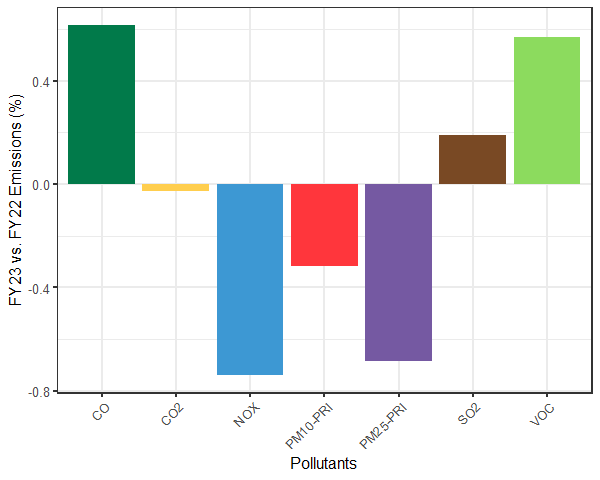

In [40]:
%%R -i st_emis -w 600 
require(ggplot2)
require(awtools)
p = ggplot(data=st_emis, aes(x=Pollutants, y=`FY23 vs. FY22 Emissions (%)`, fill=Pollutants)) + geom_col() + 
theme_bw(base_size = 16) + theme(legend.position="none", axis.text.x=element_text(angle=45,hjust=1)) + labs(x = "Pollutants", y = "FY23 vs. FY22 Emissions (%)",) + a_flat_fill()
path_fig_out = "E:/Texas A&M Transportation Institute/TxDOT_TPP_Projects - Task 5.3 Activity Forecasting Factors/Tasks/VMT_Mix/Presentation/statewide_fy23_fy22_PerDiff.png"
ggsave(path_fig_out)
p

### Non-attainment area impact

In [41]:
from pathlib import Path

pa_non_att = Path(
    r"E:\Texas A&M Transportation Institute\TxDOT_TPP_Projects - Task 5.3 Activity Forecasting Factors\Data\fy23_vmt_mix\Input\non_attainment_area.csv"
)
non_att_area = pd.read_csv(pa_non_att)

In [42]:
map_cogs = dict(
    zip(
        [
            "East Texas Council of Governments",
            "Alamo Area Council of Governments",
            "Houston-Galveston Area Council",
            "North Central Texas Council of Governments",
            "Rio Grande Council of Governments",
            "Heart of Texas Council of Governments",
            "Permian Basin Regional Planning Commission",
            "Panhandle Regional Planning Commission",
            "Ark-Tex Council of Governments",
        ],
        [
            "ETCOG",
            "AACOG",
            "HGAC",
            "NCTCOG",
            "RIOCOG",
            "HOTCOG",
            "PBRPC",
            "PRPC",
            "ATCOG",
        ],
    )
)
map_pol = {
    "Sulfur Dioxide (2010)": "SO2",
    "8-Hour Ozone (2015) [Moderate]": "NOX",
    "8-Hour Ozone (2008) [Severe 15], 8-Hour Ozone (2015) [Moderate]": "NOX",
    "8-Hour Ozone (2015) [Marginal], PM-10 (1987) [Moderate]": ["NOX", "PM10-PRI"],
    "8-Hour Ozone (2008) [Severe 15]": "NOX",
}
non_att_area["eis_poll_nei17"] = (
    non_att_area["Nonattainment Species"].str.strip().map(map_pol)
)
non_att_area["eis_poll_nei17"] = (
    non_att_area["Nonattainment Species"].str.strip().map(map_pol)
)
non_att_area = non_att_area.explode("eis_poll_nei17")
non_att_area = non_att_area.rename(
    columns={
        "COG_ABRVN": "COG",
        "Name": "county",
        "Dist_NM": "District",
        "Nonattainment Species": "Non-Attainment Status",
    }
)
non_att_area["COG_ABRVN"] = non_att_area["COG"].map(map_cogs)
non_att_area = (
    non_att_area.filter(
        items=[
            "COG_ABRVN",
            "COG",
            "eis_poll_nei17",
            "Non-Attainment Status",
            "District",
            "county",
        ]
    )
    .sort_values(["COG", "eis_poll_nei17", "District", "county"])
    .reset_index(drop=True)
)

In [43]:
emis_comp_pol.columns

Index(['eis_poll_nei17', 'county', 'fips', 'district', 'vmt_mix_dp',
       'vmt_mix_fy22', 'vmt_mix_fy23', 'vmt_dp', 'vmt_fy22', 'vmt_fy23',
       'emission_quant_dp', 'emission_quant_fy22', 'emission_quant_fy23'],
      dtype='object')

In [44]:
non_att_area_emis = non_att_area.merge(emis_comp_pol, on=["county", "eis_poll_nei17"])

In [45]:
assert set(non_att_area_emis.county) == set(
    non_att_area.county
), "Some county names did not match between Jon's non-attainment file and my AERR file."
assert all(
    non_att_area_emis.groupby(["COG_ABRVN", "fips"]).fips.nunique() == 1
), "For a COG + Pollutant, some of the counties show up multiple times."

In [46]:
non_att_area_emis_1 = non_att_area_emis.assign(
    emission_quant_diff_fy23_fy22=lambda df: df.emission_quant_fy23
    - df.emission_quant_fy22,
    emission_quant_perdiff_fy23_fy22=lambda df: 100
    * df.emission_quant_diff_fy23_fy22
    / df.emission_quant_fy22,
)

In [47]:
non_att_area_emis_nox = non_att_area_emis_1.loc[lambda df: df.eis_poll_nei17 == "NOX"]

#### Non-attainment area impact: NOx

In [48]:
ppt_non_att_nox = non_att_area_emis_nox.drop(columns="COG").rename(
    columns={
        "COG_ABRVN": "COG",
        "county": "County",
        "emission_quant_fy22": "NOx Emission 2020 + FY22 VMT-Mix",
        "emission_quant_fy23": "NOx Emission 2020 + FY23 VMT-Mix",
        "emission_quant_diff_fy23_fy22": "FY23 - FY22 NOx",
        "emission_quant_perdiff_fy23_fy22": "FY23 vs. FY22 NOx (% diff)",
    }
)

ppt_non_att_nox = (
    ppt_non_att_nox[
        [
            "COG",
            "County",
            "NOx Emission 2020 + FY22 VMT-Mix",
            "NOx Emission 2020 + FY23 VMT-Mix",
            "FY23 - FY22 NOx",
            "FY23 vs. FY22 NOx (% diff)",
        ]
    ]
    .sort_values(["NOx Emission 2020 + FY22 VMT-Mix"], ascending=False)
    .reset_index(drop=True)
)
ppt_non_att_nox[
    [
        "COG",
        "NOx Emission 2020 + FY22 VMT-Mix",
        "NOx Emission 2020 + FY23 VMT-Mix",
        "FY23 - FY22 NOx",
        "FY23 vs. FY22 NOx (% diff)",
    ]
] = ppt_non_att_nox[
    [
        "COG",
        "NOx Emission 2020 + FY22 VMT-Mix",
        "NOx Emission 2020 + FY23 VMT-Mix",
        "FY23 - FY22 NOx",
        "FY23 vs. FY22 NOx (% diff)",
    ]
].round(
    2
)
path_out = r"E:/Texas A&M Transportation Institute/TxDOT_TPP_Projects - Task 5.3 Activity Forecasting Factors/Tasks/VMT_Mix/Presentation/ppt_non_att_nox.csv"
ppt_non_att_nox.to_csv(path_out, index=False)

Saving 8.33 x 6.67 in image


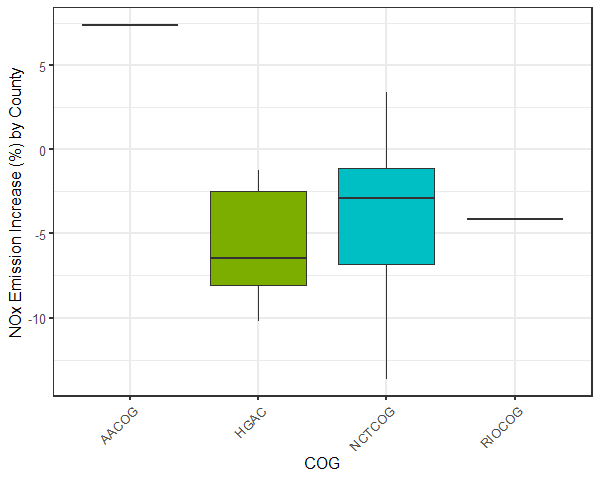

In [49]:
%%R -i non_att_area_emis_nox -w 600 
require(ggplot2)
require(awtools)
p = ggplot(data=non_att_area_emis_nox, aes(x=COG_ABRVN, y=emission_quant_perdiff_fy23_fy22, fill=COG_ABRVN)) + geom_boxplot(outlier.colour="black", outlier.shape=16,outlier.size=2, notch=FALSE) + 
theme_bw(base_size = 16) + theme(legend.position="none", axis.text.x=element_text(angle=45,hjust=1)) + labs(x = "COG", y = "NOx Emission Increase (%) by County")
path_fig_out = "E:/Texas A&M Transportation Institute/TxDOT_TPP_Projects - Task 5.3 Activity Forecasting Factors/Tasks/VMT_Mix/Presentation/nox_nonatt_fy23_fy22_PerDiff.png"
ggsave(path_fig_out)
p

Saving 8.33 x 6.67 in image


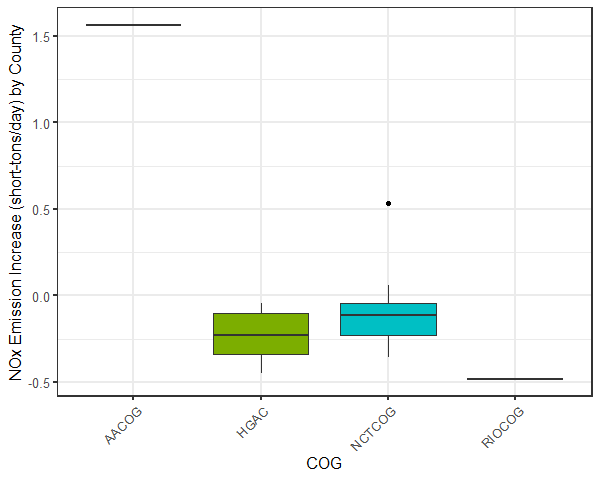

In [50]:
%%R -i non_att_area_emis_nox -w 600 
require(ggplot2)
require(awtools)
p = ggplot(data=non_att_area_emis_nox, aes(x=COG_ABRVN, y=emission_quant_diff_fy23_fy22, fill=COG_ABRVN)) + geom_boxplot(outlier.colour="black", outlier.shape=16,outlier.size=2, notch=FALSE) + 
theme_bw(base_size = 16) + theme(legend.position="none", axis.text.x=element_text(angle=45,hjust=1)) + labs(x = "COG", y = "NOx Emission Increase (short-tons/day) by County")
path_fig_out = "E:/Texas A&M Transportation Institute/TxDOT_TPP_Projects - Task 5.3 Activity Forecasting Factors/Tasks/VMT_Mix/Presentation/nox_nonatt_fy23_fy22_Diff.png"
ggsave(path_fig_out)
p

In [51]:
non_att_area_emis_1.groupby(
    ["COG_ABRVN", "eis_poll_nei17"]
).emission_quant_perdiff_fy23_fy22.describe()

count     mean     std       min      25%  \
COG_ABRVN eis_poll_nei17                                                
AACOG     NOX             1.00000  7.37698     NaN   7.37698  7.37698   
ATCOG     SO2             1.00000 -0.41841     NaN  -0.41841 -0.41841   
ETCOG     SO2             3.00000 -0.67405 1.91652  -2.88475 -1.27049   
HGAC      NOX             8.00000 -5.61959 3.40571 -10.19449 -8.05095   
HOTCOG    SO2             1.00000 -2.00283     NaN  -2.00283 -2.00283   
NCTCOG    NOX            10.00000 -3.95714 5.10097 -13.62174 -6.81500   
          SO2             1.00000 -0.42292     NaN  -0.42292 -0.42292   
PBRPC     SO2             1.00000 -1.58857     NaN  -1.58857 -1.58857   
PRPC      SO2             1.00000 -3.19758     NaN  -3.19758 -3.19758   
RIOCOG    NOX             1.00000 -4.11543     NaN  -4.11543 -4.11543   
          PM10-PRI        1.00000 -2.86380     NaN  -2.86380 -2.86380   

                              50%      75%      max  
COG_ABRVN eis_poll_nei17                             
AACOG     NOX             7.37698  7.37698  7.37698  
ATCOG     SO2            -0.41841 -0.41841 -0.41841  
ETCOG     SO2             0.34377  0.43130  0.51882  
HGAC      NOX            -6.47398 -2.44968 -1.21974  
HOTCOG    SO2            -2.00283 -2.00283 -2.00283  
NCTCOG    NOX            -2.88244 -1.11507  3.38821  
          SO2            -0.42292 -0.42292 -0.42292  
PBRPC     SO2            -1.58857 -1.58857 -1.58857  
PRPC      SO2            -3.19758 -3.19758 -3.19758  
RIOCOG    NOX            -4.11543 -4.11543 -4.11543  
          PM10-PRI       -2.86380 -2.86380 -2.86380

In [52]:
non_att_area_emis_1.groupby(
    ["COG_ABRVN", "eis_poll_nei17"]
).emission_quant_fy22.describe()

count     mean      std      min      25%  \
COG_ABRVN eis_poll_nei17                                                
AACOG     NOX             1.00000 21.17179      NaN 21.17179 21.17179   
ATCOG     SO2             1.00000  0.00435      NaN  0.00435  0.00435   
ETCOG     SO2             3.00000  0.00327  0.00034  0.00290  0.00312   
HGAC      NOX             8.00000  7.43904 12.01991  1.43983  1.98440   
HOTCOG    SO2             1.00000  0.00524      NaN  0.00524  0.00524   
NCTCOG    NOX            10.00000  7.22123  7.14691  1.30130  3.58640   
          SO2             1.00000  0.00643      NaN  0.00643  0.00643   
PBRPC     SO2             1.00000  0.00432      NaN  0.00432  0.00432   
PRPC      SO2             1.00000  0.00126      NaN  0.00126  0.00126   
RIOCOG    NOX             1.00000 11.69539      NaN 11.69539 11.69539   
          PM10-PRI        1.00000  1.12519      NaN  1.12519  1.12519   

                              50%      75%      max  
COG_ABRVN eis_poll_nei17                             
AACOG     NOX            21.17179 21.17179 21.17179  
ATCOG     SO2             0.00435  0.00435  0.00435  
ETCOG     SO2             0.00334  0.00345  0.00357  
HGAC      NOX             3.39037  4.96373 36.95107  
HOTCOG    SO2             0.00524  0.00524  0.00524  
NCTCOG    NOX             4.28939  6.78557 23.91621  
          SO2             0.00643  0.00643  0.00643  
PBRPC     SO2             0.00432  0.00432  0.00432  
PRPC      SO2             0.00126  0.00126  0.00126  
RIOCOG    NOX            11.69539 11.69539 11.69539  
          PM10-PRI        1.12519  1.12519  1.12519

#### Non-attainment area impact: PM10

In [53]:
non_att_area_emis_1.eis_poll_nei17.unique()

array(['NOX', 'SO2', 'PM10-PRI'], dtype=object)

In [54]:
non_att_area_emis_pm10 = non_att_area_emis_1.loc[
    lambda df: df.eis_poll_nei17 == "PM10-PRI"
]

In [55]:
non_att_area_emis_pm10.T

,28
COG_ABRVN,RIOCOG
COG,Rio Grande Council of Governments
eis_poll_nei17,PM10-PRI
Non-Attainment Status,"8-Hour Ozone (2015) [Marginal], PM-10 (1987) [..."
District,El Paso
county,El Paso
fips,48141
district,El Paso
vmt_mix_dp,4.00000
vmt_mix_fy22,4.00000


## County Emission Inc w.r.t to VMT-Mix and VMT Change + Emission Rate

In [56]:
cnty_emis_by_vmt_mix = suft_emis_vmt_onroad_anly_1.loc[
    lambda df: df.eis_poll_nei17 == "NOX"
]

In [57]:
254 * 22 * 5 * 5

139700

In [58]:
test = cnty_emis_by_vmt_mix.groupby(
    ["road_type_id", "source_type_id", "fuel_type_id"]
).vmt_mix_dp.count()

In [59]:
cnty_emis_by_vmt_mix1 = (
    cnty_emis_by_vmt_mix.assign(
        vmt_mix_perdiff_fy23_fy22=lambda df: 100
        * (df.vmt_mix_fy23_13_21 - df.vmt_mix_fy22_13_19)
        / df.vmt_mix_fy22_13_19
    )
    .sort_values("vmt_mix_perdiff_fy23_fy22", ascending=False)
    .filter(
        items=[
            "eis_poll_nei17",
            "county",
            "district",
            "road_type_id",
            "sut_fueltype_lab",
            "vmt_mix_perdiff_fy23_fy22",
            "emission_rate_calc",
            "emission_quant_fy22",
            "emission_quant_fy23",
            "vmt_fy22",
            "vmt_fy23",
            "vmt_mix_fy22_13_19",
            "vmt_mix_fy23_13_21",
        ]
    )
)
sh_tn_to_grm = 907185
cnty_emis_by_vmt_mix1["vmt_mix_fy22_13_19"] = (
    cnty_emis_by_vmt_mix1["vmt_mix_fy22_13_19"] * 100
)
cnty_emis_by_vmt_mix1["vmt_mix_fy23_13_21"] = (
    cnty_emis_by_vmt_mix1["vmt_mix_fy23_13_21"] * 100
)
cnty_emis_by_vmt_mix1["emission_rate_calc_gm"] = (
    cnty_emis_by_vmt_mix1.emission_rate_calc * sh_tn_to_grm
)
cnty_emis_by_vmt_mix1["emission_quant_fy22_gm"] = (
    cnty_emis_by_vmt_mix1.emission_quant_fy22 * sh_tn_to_grm
)
cnty_emis_by_vmt_mix1["emission_quant_fy23_gm"] = (
    cnty_emis_by_vmt_mix1.emission_quant_fy23 * sh_tn_to_grm
)
cnty_emis_by_vmt_mix1["emission_quant_diff_fy23_fy22_gm"] = (
    cnty_emis_by_vmt_mix1.emission_quant_fy23_gm
    - cnty_emis_by_vmt_mix1.emission_quant_fy22_gm
)
cnty_emis_by_vmt_mix1["vmt_diff_fy23_fy22"] = (
    cnty_emis_by_vmt_mix1.vmt_fy23 - cnty_emis_by_vmt_mix1.vmt_fy22
)
cnty_emis_by_vmt_mix1 = cnty_emis_by_vmt_mix1.drop(
    columns=["emission_rate_calc", "emission_quant_fy22", "emission_quant_fy23"]
)

In [60]:
cnty_emis_by_vmt_mix1.vmt_mix_fy23_13_21.describe()

count   13,090.00000
mean         4.54545
std         12.01765
min          0.00006
25%          0.05180
50%          0.19749
75%          1.91519
max         73.18006
Name: vmt_mix_fy23_13_21, dtype: float64

In [61]:
cnty_emis_by_vmt_mix1.vmt_mix_fy23_13_21.describe()

count   13,090.00000
mean         4.54545
std         12.01765
min          0.00006
25%          0.05180
50%          0.19749
75%          1.91519
max         73.18006
Name: vmt_mix_fy23_13_21, dtype: float64

In [62]:
cnty_emis_by_vmt_mix1[
    [
        "vmt_mix_perdiff_fy23_fy22",
        "vmt_fy22",
        "vmt_fy23",
        "vmt_mix_fy22_13_19",
        "vmt_mix_fy23_13_21",
        "emission_rate_calc_gm",
        "emission_quant_fy22_gm",
        "emission_quant_fy23_gm",
        "emission_quant_diff_fy23_fy22_gm",
        "vmt_diff_fy23_fy22",
    ]
] = cnty_emis_by_vmt_mix1[
    [
        "vmt_mix_perdiff_fy23_fy22",
        "vmt_fy22",
        "vmt_fy23",
        "vmt_mix_fy22_13_19",
        "vmt_mix_fy23_13_21",
        "emission_rate_calc_gm",
        "emission_quant_fy22_gm",
        "emission_quant_fy23_gm",
        "emission_quant_diff_fy23_fy22_gm",
        "vmt_diff_fy23_fy22",
    ]
].round(
    2
)

In [63]:
emis_comp_pol_cnty.groupby(["eis_poll_nei17", "county", "district"])

In [64]:
cnty_emis_filt = (
    emis_comp_pol_cnty.loc[lambda df: df.eis_poll_nei17 == "NOX"]
    .filter(
        items=[
            "eis_poll_nei17",
            "county",
            "district",
            "emission_quant_fy22",
            "emission_quant_fy23",
            "emission_quant_diff_fy23_fy22",
            "emission_quant_perdiff_fy23_fy22",
        ]
    )
    .sort_values("emission_quant_perdiff_fy23_fy22", ascending=False)
    .reset_index(drop=True)
)

In [65]:
cnty_emis_brkdn = cnty_emis_filt.merge(
    cnty_emis_by_vmt_mix1, on=["eis_poll_nei17", "county", "district"]
)

Focus on the counties with the largest percent change and show what is happing in the individual row (CLhT, PC, PT etc.). Show that +ve changes + -ve changes cancel each other. And that emission rates for heavy duty vehicles are quite high. 

In [66]:
path_out = r"E:/Texas A&M Transportation Institute/TxDOT_TPP_Projects - Task 5.3 Activity Forecasting Factors/Tasks/VMT_Mix/Presentation/cnty_emis_stats.csv"
cnty_emis_filt.to_csv(path_out, index=False)

path_out = r"E:/Texas A&M Transportation Institute/TxDOT_TPP_Projects - Task 5.3 Activity Forecasting Factors/Tasks/VMT_Mix/Presentation/cnty_emis_stats_with_breakdown.csv"
cnty_emis_brkdn.to_csv(path_out, index=False)

In [67]:
cnty_top_5 = cnty_emis_filt.head(5)
cnty_tail_5 = cnty_emis_filt.tail(5)

In [68]:
cnty_top_5 = cnty_top_5.rename(
    columns={
        "county": "County",
        "emission_quant_fy22": "NOx Emission 2020 + FY22 VMT-Mix",
        "emission_quant_fy23": "NOx Emission 2020 + FY23 VMT-Mix",
        "emission_quant_diff_fy23_fy22": "FY23 - FY22 NOx",
        "emission_quant_perdiff_fy23_fy22": "FY23 vs. FY22 NOx (% diff)",
    }
)
cnty_top_5 = cnty_top_5.round(2)
cnty_top_5.to_clipboard()

In [69]:
cnty_tail_5 = cnty_tail_5.rename(
    columns={
        "county": "County",
        "emission_quant_fy22": "NOx Emission 2020 + FY22 VMT-Mix",
        "emission_quant_fy23": "NOx Emission 2020 + FY23 VMT-Mix",
        "emission_quant_diff_fy23_fy22": "FY23 - FY22 NOx",
        "emission_quant_perdiff_fy23_fy22": "FY23 vs. FY22 NOx (% diff)",
    }
)
cnty_tail_5 = cnty_tail_5.round(2)
cnty_tail_5.to_clipboard()

In [74]:
cnty_emis_brkdn.columns

Index(['eis_poll_nei17', 'county', 'district', 'emission_quant_fy22',
       'emission_quant_fy23', 'emission_quant_diff_fy23_fy22',
       'emission_quant_perdiff_fy23_fy22', 'road_type_id', 'sut_fueltype_lab',
       'vmt_mix_perdiff_fy23_fy22', 'vmt_fy22', 'vmt_fy23',
       'vmt_mix_fy22_13_19', 'vmt_mix_fy23_13_21', 'emission_rate_calc_gm',
       'emission_quant_fy22_gm', 'emission_quant_fy23_gm',
       'emission_quant_diff_fy23_fy22_gm', 'vmt_diff_fy23_fy22'],
      dtype='object')

In [75]:
cnty_emis_brkdn_top5 = cnty_emis_brkdn.loc[
    lambda df: df.county.isin(set(cnty_top_5.County))
]
cnty_emis_brkdn_tail5 = cnty_emis_brkdn.loc[
    lambda df: df.county.isin(set(cnty_tail_5.County))
]

In [136]:
cnty_emis_brkdn_top5

,eis_poll_nei17,county,district,emission_quant_fy22,emission_quant_fy23,emission_quant_diff_fy23_fy22,emission_quant_perdiff_fy23_fy22,road_type_id,sut_fueltype_lab,vmt_mix_perdiff_fy23_fy22,vmt_fy22,vmt_fy23,vmt_mix_fy22_13_19,vmt_mix_fy23_13_21,emission_rate_calc_gm,emission_quant_fy22_gm,emission_quant_fy23_gm,emission_quant_diff_fy23_fy22_gm,vmt_diff_fy23_fy22
0,NOX,Eastland,Brownwood,1.80382,2.28401,0.48018,26.62017,2,CLhT_Diesel,42.32000,"85,421,033.90000","121,573,299.20000",27.42000,39.02000,4.40000,"1,030,813.85000","1,467,079.42000","436,265.57000","36,152,265.30000"
1,NOX,Eastland,Brownwood,1.80382,2.28401,0.48018,26.62017,2,CShT_Gas,42.32000,946.18000,"1,346.62000",0.00000,0.00000,0.80000,2.07000,2.94000,0.87000,400.45000
2,NOX,Eastland,Brownwood,1.80382,2.28401,0.48018,26.62017,2,CShT_Diesel,42.32000,"7,197,665.13000","10,243,892.59000",2.31000,3.29000,3.66000,"72,237.54000","102,810.22000","30,572.69000","3,046,227.46000"
3,NOX,Eastland,Brownwood,1.80382,2.28401,0.48018,26.62017,2,RT_Diesel,23.58000,"120,951.88000","149,471.33000",0.04000,0.05000,4.78000,"1,582.98000","1,956.23000",373.25000,"28,519.45000"
4,NOX,Eastland,Brownwood,1.80382,2.28401,0.48018,26.62017,2,MH_Diesel,23.58000,"182,581.37000","225,632.54000",0.06000,0.07000,4.90000,"2,449.40000","3,026.95000",577.55000,"43,051.17000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,NOX,Atascosa,San Antonio,1.74840,1.98676,0.23835,13.63274,5,OBus_Diesel,-17.04000,"187,628.75000","155,660.49000",0.27000,0.22000,5.14000,"2,640.09000","2,190.27000",-449.82000,"-31,968.26000"
348,NOX,Atascosa,San Antonio,1.74840,1.98676,0.23835,13.63274,5,SBus_Gas,-17.04000,"1,835.17000","1,522.49000",0.00000,0.00000,1.25000,6.29000,5.22000,-1.07000,-312.68000
349,NOX,Atascosa,San Antonio,1.74840,1.98676,0.23835,13.63274,5,TBus_Diesel,-17.04000,"61,286.34000","50,844.35000",0.09000,0.07000,3.31000,555.61000,460.94000,-94.66000,"-10,441.99000"
350,NOX,Atascosa,San Antonio,1.74840,1.98676,0.23835,13.63274,2,MC_Gas,-21.06000,"522,281.41000","412,275.88000",0.16000,0.13000,0.72000,"1,030.30000",813.29000,-217.01000,"-110,005.52000"


## VMT-Mix Comp

In [76]:
vmix_fy22 = (
    vmtmix_fy22_13_19.loc[lambda df: df.yearID == 2020]
    .drop_duplicates(
        [
            "txdot_dist",
            "district",
            "mvs_rdtype_nm",
            "mvs_rdtype",
            "dowagg",
            "yearID",
            "tod",
            "sourceTypeName",
            "sourceTypeID",
            "fuelTypeID",
            "fuelTypeDesc",
        ]
    )
    .drop(columns="fips")
)
vmix_fy23 = (
    vmtmix_fy23_13_21.loc[lambda df: df.yearID == 2020]
    .drop_duplicates(
        [
            "txdot_dist",
            "district",
            "mvs_rdtype_nm",
            "mvs_rdtype",
            "dowagg",
            "yearID",
            "tod",
            "sourceTypeName",
            "sourceTypeID",
            "fuelTypeID",
            "fuelTypeDesc",
        ]
    )
    .drop(columns="fips")
)

In [77]:
vmtmix_comp = vmix_fy22.merge(
    vmix_fy23,
    on=[
        "txdot_dist",
        "district",
        "mvs_rdtype_nm",
        "mvs_rdtype",
        "dowagg",
        "yearID",
        "tod",
        "sourceTypeName",
        "sourceTypeID",
        "fuelTypeID",
        "fuelTypeDesc",
    ],
    suffixes=["_fy22", "_fy23"],
)
vmtmix_comp.vmt_mix_fy22 = vmtmix_comp.vmt_mix_fy22 * 100
vmtmix_comp.vmt_mix_fy23 = vmtmix_comp.vmt_mix_fy23 * 100

In [78]:
vmtmix_comp["vmt_mix_diff_fy23_fy22"] = (
    vmtmix_comp.vmt_mix_fy23 - vmtmix_comp.vmt_mix_fy22
)
vmtmix_comp["vmt_mix_perdiff_fy23_fy22"] = (
    100 * vmtmix_comp.vmt_mix_diff_fy23_fy22 / vmtmix_comp.vmt_mix_fy22
)
vmtmix_comp = vmtmix_comp.sort_values(
    "vmt_mix_perdiff_fy23_fy22", ascending=False
).reset_index(drop=True)

Look in the districts with the most change and see what offsets large +ve values (hint: PC, PT,...)

In [79]:
vmtmix_comp.columns

Index(['dgcode_fy22', 'txdot_dist', 'district', 'mvs_rdtype_nm', 'mvs_rdtype',
       'dowagg', 'yearID', 'tod', 'sourceTypeName', 'sourceTypeID',
       'fuelTypeID', 'fuelTypeDesc', 'vmt_mix_fy22', 'dgcode_fy23',
       'vmt_mix_fy23', 'vmt_mix_diff_fy23_fy22', 'vmt_mix_perdiff_fy23_fy22'],
      dtype='object')

In [80]:
len(
    vmtmix_comp[
        [
            "sourceTypeID",
            "fuelTypeID",
        ]
    ].drop_duplicates()
)

24

In [81]:
5 * 5 * 4 * 25 * 24
# 5 TOD, 5 Rd Type, 5 Day Type, 25 Districts, 24 SUTFT

60000

Saving 8.33 x 6.67 in image
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


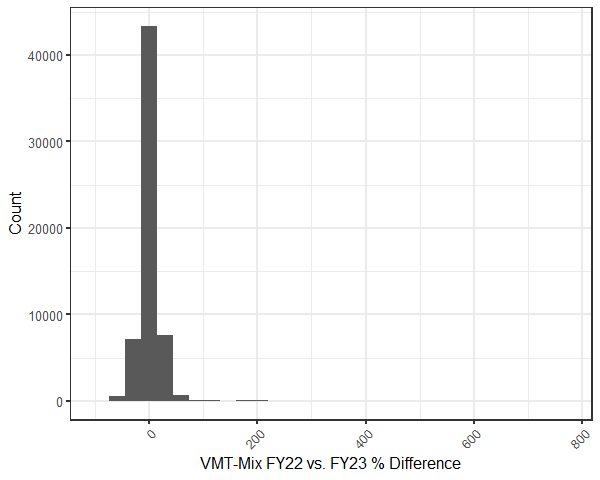

In [82]:
%%R -i vmtmix_comp -w 600 
require(ggplot2)
require(awtools)
p = ggplot(data=vmtmix_comp, aes(x=vmt_mix_perdiff_fy23_fy22)) + geom_histogram() + 
theme_bw(base_size = 16) + theme(legend.position="none", axis.text.x=element_text(angle=45,hjust=1)) + labs(x = "VMT-Mix FY22 vs. FY23 % Difference", y = "Count",) + a_flat_fill()
path_fig_out = "E:/Texas A&M Transportation Institute/TxDOT_TPP_Projects - Task 5.3 Activity Forecasting Factors/Tasks/VMT_Mix/Presentation/vmt_mix_perdiff_fy23_fy22.png"
ggsave(path_fig_out)
p

Saving 8.33 x 6.67 in image


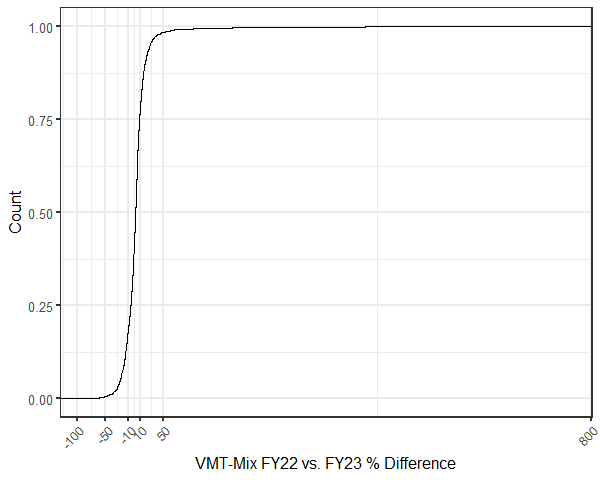

In [91]:
%%R -i vmtmix_comp -w 600 
require(ggplot2)
require(awtools)
p = ggplot(data=vmtmix_comp, aes(x=vmt_mix_perdiff_fy23_fy22)) + stat_ecdf() + 
theme_bw(base_size = 16) + theme(legend.position="none", axis.text.x=element_text(angle=45,hjust=1)) + labs(x = "VMT-Mix FY22 vs. FY23 % Difference", y = "Count",) + scale_x_continuous(breaks=c(-100, -50, -10, 10, 50,800)) + a_flat_fill()
path_fig_out = "E:/Texas A&M Transportation Institute/TxDOT_TPP_Projects - Task 5.3 Activity Forecasting Factors/Tasks/VMT_Mix/Presentation/vmt_mix_perdiff_fy23_fy22_ecdf.png"
ggsave(path_fig_out)
p

In [92]:
vmtmix_comp.vmt_mix_perdiff_fy23_fy22.describe()

count   60,000.00000
mean         3.19081
std         29.43275
min        -87.21002
25%         -6.01294
50%          2.38563
75%          9.13917
max        758.98984
Name: vmt_mix_perdiff_fy23_fy22, dtype: float64

In [94]:
vmtmix_comp.vmt_mix_perdiff_fy23_fy22.quantile(0.05)

-24.676715536264886

In [103]:
vmtmix_comp.vmt_mix_perdiff_fy23_fy22.quantile(0.99)

66.81256965018005

In [106]:
vmtmix_comp_dig = vmtmix_comp.loc[lambda df: df.vmt_mix_perdiff_fy23_fy22 >= 66.8]

In [107]:
vmtmix_comp_dig.district.unique()

array(['San Angelo', 'Bryan', 'Corpus Christi', 'Lubbock', 'Brownwood',
       'San Antonio', 'Wichita Falls', 'Amarillo', 'Waco', 'Dallas'],
      dtype=object)

In [118]:
vmtmix_comp_dig1 = vmtmix_comp_dig.drop_duplicates(
    ["district", "sourceTypeName", "fuelTypeDesc"]
)

In [122]:
vmtmix_comp_dig1.groupby(["sourceTypeName", "fuelTypeDesc"]).agg(
    district=("district", set)
)

district
sourceTypeName               fuelTypeDesc                                                   
Combination Long-haul Truck  Diesel Fuel   {Bryan, Waco, San Angelo, San Antonio, Brownwood}
Combination Short-haul Truck Diesel Fuel   {Bryan, Waco, San Angelo, San Antonio, Brownwood}
                             Gasoline      {Bryan, Waco, San Angelo, San Antonio, Brownwood}
Motor Home                   Diesel Fuel                                  {Bryan, Brownwood}
                             Gasoline                                     {Bryan, Brownwood}
Motorcycle                   Gasoline                                           {San Angelo}
Other Buses                  Diesel Fuel   {Amarillo, Lubbock, San Angelo, Dallas, Corpus...
                             Gasoline      {Amarillo, Lubbock, San Angelo, Dallas, Corpus...
Refuse Truck                 Diesel Fuel                                  {Bryan, Brownwood}
                             Gasoline                                     {Bryan, Brownwood}
School Bus                   Diesel Fuel   {Amarillo, Lubbock, San Angelo, Dallas, Corpus...
                             Gasoline      {Amarillo, Lubbock, San Angelo, Dallas, Corpus...
Single Unit Long-haul Truck  Diesel Fuel                                  {Bryan, Brownwood}
                             Gasoline                                     {Bryan, Brownwood}
Single Unit Short-haul Truck Diesel Fuel                                  {Bryan, Brownwood}
                             Gasoline                                     {Bryan, Brownwood}
Transit Bus                  Diesel Fuel   {Amarillo, Lubbock, San Angelo, Dallas, Corpus...
                             Gasoline      {Amarillo, Lubbock, San Angelo, Dallas, Corpus...

In [133]:
vmtmix_comp_dig_low = vmtmix_comp.loc[lambda df: df.vmt_mix_perdiff_fy23_fy22 <= -50]

In [134]:
vmtmix_comp_dig_low1 = vmtmix_comp_dig_low.drop_duplicates(
    ["district", "sourceTypeName", "fuelTypeDesc"]
)
vmtmix_comp_dig_low1.groupby(["sourceTypeName", "fuelTypeDesc"]).agg(
    district=("district", set)
)

district
sourceTypeName               fuelTypeDesc                                 
Combination Long-haul Truck  Diesel Fuel                         {Atlanta}
Combination Short-haul Truck Diesel Fuel                         {Atlanta}
                             Gasoline                            {Atlanta}
Motorcycle                   Gasoline                       {Tyler, Paris}
Other Buses                  Diesel Fuel   {Waco, Brownwood, Tyler, Paris}
                             Gasoline      {Waco, Brownwood, Tyler, Paris}
School Bus                   Diesel Fuel   {Waco, Brownwood, Tyler, Paris}
                             Gasoline      {Waco, Brownwood, Tyler, Paris}
Transit Bus                  Diesel Fuel   {Waco, Brownwood, Tyler, Paris}
                             Gasoline      {Waco, Brownwood, Tyler, Paris}

In [135]:
vmtmix_comp_dig_low2 = (
    vmtmix_comp_dig_low1.groupby(["sourceTypeName", "fuelTypeDesc"], as_index=False)
    .agg(district=("district", set))
    .values
)

## R+Python Example

In [ ]:
import seaborn.objects as so

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1, 1)
sns.barplot(st_emis, x="Pollutants", y="FY23 vs. FY22 Emissions (%)", ax=ax)
ax.set_xlabel("Pollutants")
ax.set_ylabel("Emission Percent Diff")
fig.tight_layout()
fig.autofmt_xdate()

In [ ]:
# # https://github.com/rpy2/rpy2/blob/master/doc/notebooks/introduction_nb.md
# import rpy2.robjects as robjects
# # R package names
# packnames = ('ggplot2',)

# # import rpy2's package module
# import rpy2.robjects.packages as rpackages

# if all(rpackages.isinstalled(x) for x in packnames):
#     have_tutorial_packages = True
# else:
#     have_tutorial_packages = False
# have_tutorial_packages

In [ ]:
# if not have_tutorial_packages:
#     # R vector of strings
#     from rpy2.robjects.vectors import StrVector
#     # file
#     packnames_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
#     if len(packnames_to_install) > 0:
#         utils.install_packages(StrVector(packnames_to_install))

In [ ]:
# # https://github.com/rpy2/rpy2/blob/master/doc/notebooks/jupyter.md
# from rpy2.robjects.packages import importr
# import rpy2.robjects.lib.ggplot2 as gp
# from rpy2.ipython.ggplot import image_png
# from rpy2.robjects import rl

In [ ]:
# p = (gp.ggplot(data=rl("st_emis")) + gp.aes(x=rl("Pollutant"), y=rl("emission_quant_perdiff_fy22_dp")) + gp.geom_col()  + gp.labs(x = "Pollutants", y = "Emission Percent Difference")) + gp.theme_light(base_size = 14) +  gp.theme(axis_text_x=gp.element_text(angle=45,hjust=1))
# #image_png(p, width=600)